In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression # Used for the data generation model

# Configure plotting style
sns.set_style("whitegrid")

In [14]:
# --- 1. Data Generation (You can skip this, if you get data from database ---

TOTAL_HOURS = 90 * 24 

def generate_energy_data(n_hours):
    """Generates synthetic multivariate data for energy analysis."""
    dates = pd.date_range(start='2025-01-01', periods=n_hours, freq='h')
    df = pd.DataFrame(index=dates)

    # Features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['temp'] = 15 + 10 * np.sin(2 * np.pi * df.index.dayofyear / 365) + np.random.normal(0, 2, n_hours)
    df['season_factor'] = np.where(df.index.month.isin([6, 7, 8]), 1.5, 0.8)
    df['peak_time_factor'] = np.where(df['hour'].isin([8, 18, 19]), 1.5, 0.8)

    # Net Energy (Target): Generation - Load + Noise
    wind = 10 + 5 * np.random.rand(n_hours) * df['season_factor']
    sun = 5 * np.maximum(0, np.sin(df['hour'] / 12 * np.pi)) * df['season_factor']
    heat_pump_load = (df['temp'] < 10) * 15 * df['peak_time_factor'] * 0.5
    df['Net_Energy'] = (wind + sun) - heat_pump_load + np.random.normal(0, 1, n_hours)

    # Introduce synthetic data quality issues for reliability check
    df.loc[df.sample(frac=0.01).index, 'Net_Energy'] = np.nan # 1% Missing values
    df.loc[df.sample(frac=0.005).index, 'temp'] = 500 # Outliers in temperature
    df['day_of_week'] = df['day_of_week'].astype(str) # Incorrect data type
    
    return df

energy_df = generate_energy_data(TOTAL_HOURS)


In [12]:
# --- 2. Data Reliability & Quality Checks ---

class DataReliabilityChecker:
    """Performs checks for missing data, data types, and outliers."""
    
    def __init__(self, df):
        self.df = df.copy()

    def check_data_types(self):
        """Identifies and reports non-numeric data types where numerical are expected."""
        print("--- Data Type Check (Qualitative) ---")
        print(self.df.info())
        
        # Example fix: Convert 'day_of_week' back to numeric
        if 'day_of_week' in self.df.columns and self.df['day_of_week'].dtype == object:
            self.df['day_of_week'] = pd.to_numeric(self.df['day_of_week'], errors='coerce')
            print("\n*Action: 'day_of_week' converted to numeric. Reliability restored.*")

    def handle_missing_data(self):
        """Quantifies missing data and fills it."""
        print("\n--- Missing Data Check (Quantitative) ---")
        missing_count = self.df.isnull().sum()
        print("Missing Value Count:\n", missing_count[missing_count > 0])
        
        # Action: Fill missing 'Net_Energy' with the mean, and drop any remaining NaNs
        if 'Net_Energy' in self.df.columns and self.df['Net_Energy'].isnull().any():
            self.df['Net_Energy'].fillna(self.df['Net_Energy'].mean(), inplace=True)
            print("*Action: Missing 'Net_Energy' values filled with mean. Reliability enhanced.*")
        
        # Drop rows where critical features (like temp) are still NaN after type coercion
        self.df.dropna(inplace=True)
        return self.df
    
    def detect_and_handle_outliers(self, column):
        """Uses IQR (Interquartile Range) method to detect and cap outliers."""
        Q1 = self.df[column].quantile(0.25)
        Q3 = self.df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = self.df[(self.df[column] < lower_bound) | (self.df[column] > upper_bound)]
        
        print(f"\n--- Outlier Check ({column}) ---")
        print(f"Detected {len(outliers)} outliers (e.g., Temperature > {upper_bound:.2f}°C).")
        
        # Action: Cap outliers (Winsorization)
        self.df[column] = np.where(self.df[column] > upper_bound, upper_bound, self.df[column])
        self.df[column] = np.where(self.df[column] < lower_bound, lower_bound, self.df[column])
        print(f"*Action: Outliers in '{column}' capped. Reliability ensured.*")
        
        return len(outliers)

# Run Reliability Checks
checker = DataReliabilityChecker(energy_df)
checker.check_data_types()
energy_df = checker.handle_missing_data()
checker.detect_and_handle_outliers('temp')

--- Data Type Check (Qualitative) ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2160 entries, 2025-01-01 00:00:00 to 2025-03-31 23:00:00
Freq: h
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hour              2160 non-null   int32  
 1   day_of_week       2160 non-null   int64  
 2   temp              2160 non-null   float64
 3   season_factor     2160 non-null   float64
 4   peak_time_factor  2160 non-null   float64
 5   Net_Energy        2160 non-null   float64
dtypes: float64(4), int32(1), int64(1)
memory usage: 174.2 KB
None

--- Missing Data Check (Quantitative) ---
Missing Value Count:
 Series([], dtype: int64)

--- Outlier Check (temp) ---
Detected 0 outliers (e.g., Temperature > 32.65°C).
*Action: Outliers in 'temp' capped. Reliability ensured.*


0


QUANTITATIVE ANALYSIS: Descriptive Statistics
                   count       mean           std        min        25%  \
hour              2160.0  11.500000  6.923789e+00   0.000000   5.750000   
day_of_week       2160.0   3.022222  2.000340e+00   0.000000   1.000000   
temp              2160.0  21.486560  3.715747e+00  10.648769  18.758909   
season_factor     2160.0   0.800000  1.110480e-16   0.800000   0.800000   
peak_time_factor  2160.0   0.887500  2.315568e-01   0.800000   0.800000   
Net_Energy        2160.0  13.255756  2.179834e+00   7.846042  11.610640   

                        50%        75%        max  
hour              11.500000  17.250000  23.000000  
day_of_week        3.000000   5.000000   6.000000  
temp              21.884497  24.315428  32.650206  
season_factor      0.800000   0.800000   0.800000  
peak_time_factor   0.800000   0.800000   1.500000  
Net_Energy        13.195234  14.782461  19.815967  

QUANTITATIVE ANALYSIS: Correlation Matrix (Feature Relationshi

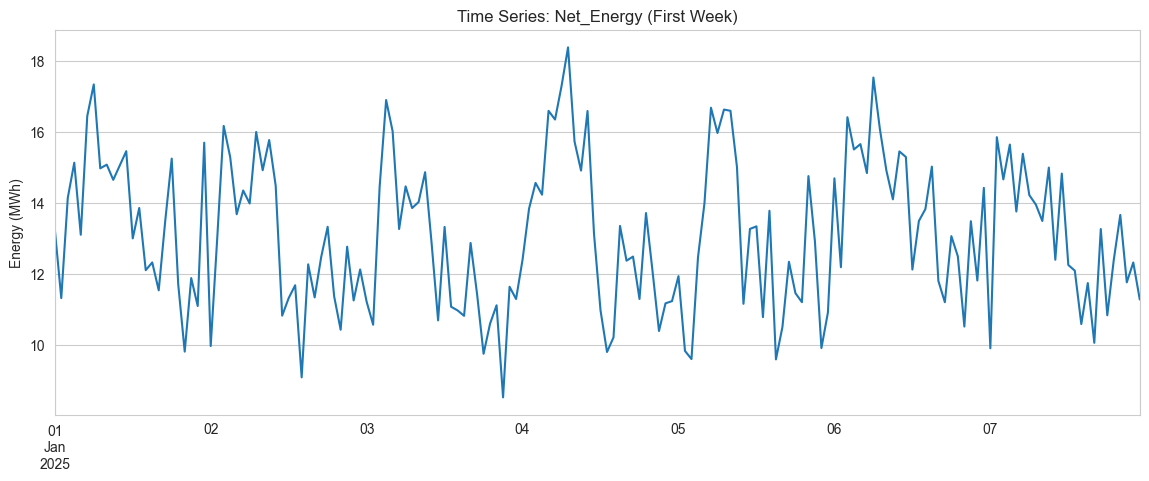

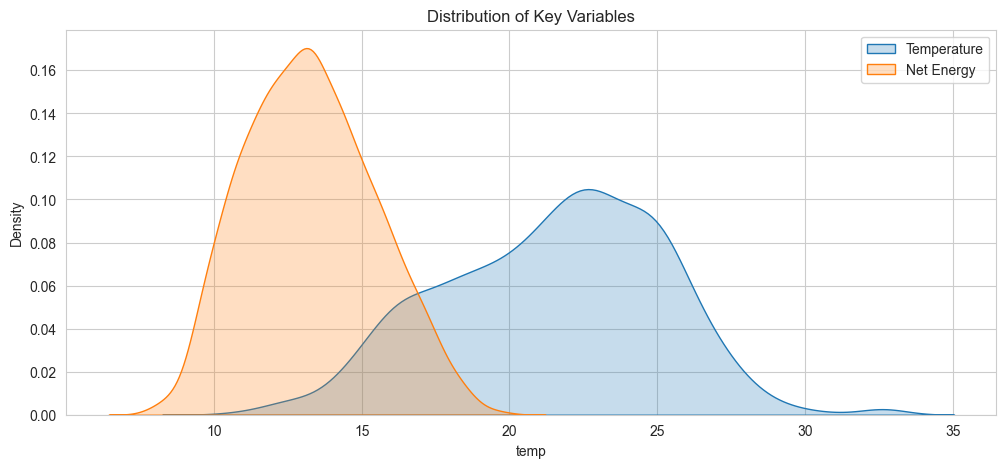

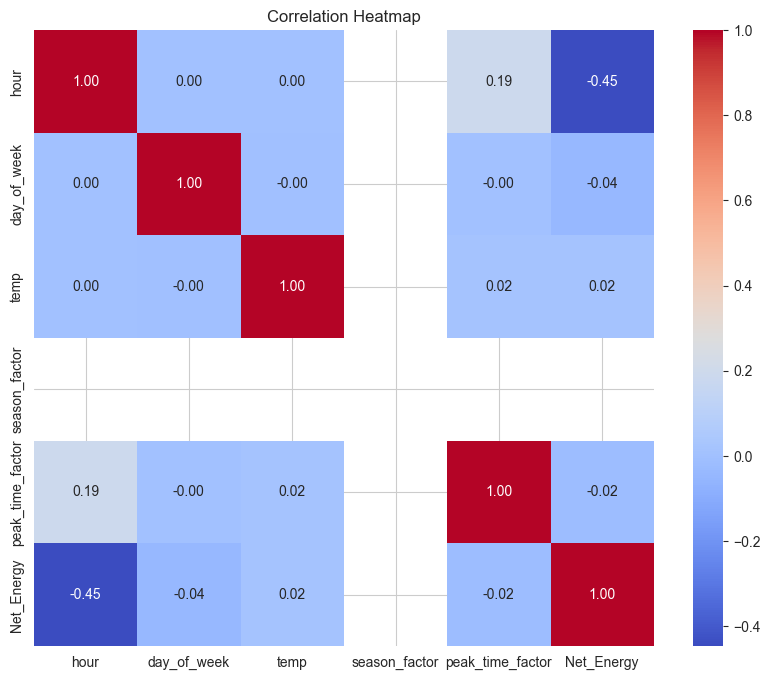

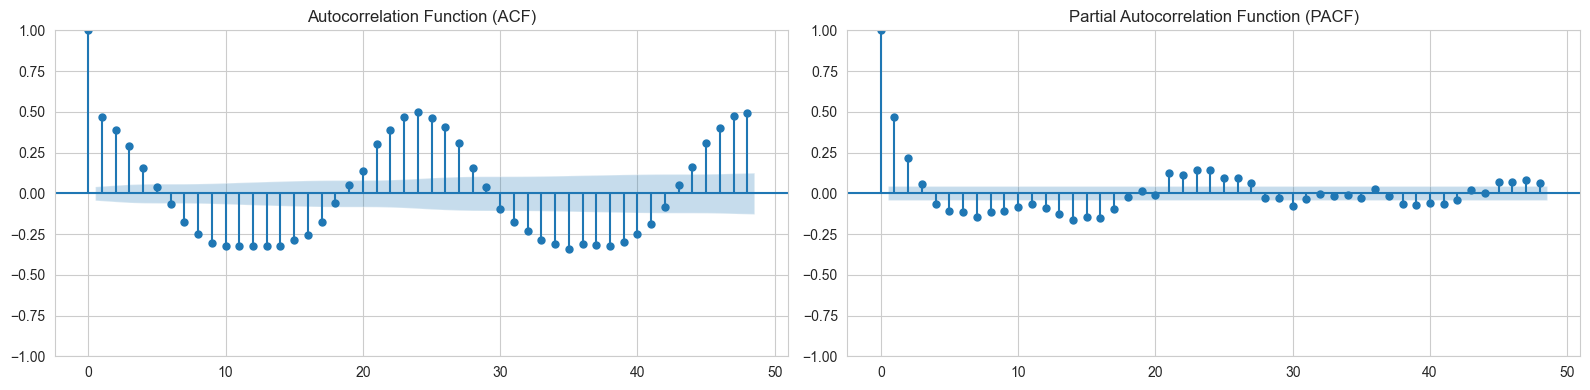

In [13]:
# --- 3. Qualitative and Quantitative Data Analysis ---

class EnergyDataAnalyzer:
    """Performs descriptive, correlation, and stationarity analysis."""
    
    def __init__(self, df, target_col='Net_Energy'):
        self.df = df
        self.target = target_col
        
    def qualitative_analysis(self):
        """Displays descriptive statistics and key distributions."""
        print("\n" + "="*70)
        print("QUANTITATIVE ANALYSIS: Descriptive Statistics")
        print("="*70)
        print(self.df.describe().T)
        
        # Qualitative Plot 1: Time Series Plot
        plt.figure(figsize=(14, 5))
        self.df[self.target].iloc[:24*7].plot(title=f'Time Series: {self.target} (First Week)')
        plt.ylabel('Energy (MWh)')
        plt.savefig('qual_time_series.png')
        
        # Qualitative Plot 2: Feature Distribution
        plt.figure(figsize=(12, 5))
        sns.kdeplot(self.df['temp'], fill=True, label='Temperature')
        sns.kdeplot(self.df[self.target], fill=True, label='Net Energy')
        plt.title('Distribution of Key Variables')
        plt.legend()
        plt.savefig('qual_distributions.png')
        
    def quantitative_analysis(self):
        """Performs correlation, stationarity, and seasonality analysis."""
        
        # Quantitative Check 1: Correlation Matrix
        print("\n" + "="*70)
        print("QUANTITATIVE ANALYSIS: Correlation Matrix (Feature Relationships)")
        print("="*70)
        
        correlation_matrix = self.df.corr()
        print(correlation_matrix[self.target].sort_values(ascending=False))
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
        plt.title('Correlation Heatmap')
        plt.savefig('quant_correlation.png')
        
        # Quantitative Check 2: Stationarity Test (ADF)
        print("\n" + "="*70)
        print("QUANTITATIVE ANALYSIS: Stationarity Test (ADF)")
        print("="*70)
        
        result = adfuller(self.df[self.target], autolag='AIC')
        p_value = result[1]
        
        print(f'ADF Statistic: {result[0]:.4f}')
        print(f'P-value: {p_value:.4f}')
        
        if p_value <= 0.05:
            print("Conclusion: The time series is **Stationary** (Reject null hypothesis).")
        else:
            print("Conclusion: The time series is **Non-Stationary** (Requires differencing for ARIMA).")
            
        # Quantitative Check 3: Seasonality/Autocorrelation (ACF/PACF)
        print("\n" + "="*70)
        print("QUANTITATIVE ANALYSIS: Autocorrelation (Seasonality Check)")
        print("="*70)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        plot_acf(self.df[self.target], lags=48, ax=axes[0], title='Autocorrelation Function (ACF)')
        plot_pacf(self.df[self.target], lags=48, ax=axes[1], title='Partial Autocorrelation Function (PACF)')
        
        print("Plotting ACF/PACF helps identify the strength of seasonal patterns and suggest ARIMA/SARIMA model parameters (p, q, P, Q).")
        plt.tight_layout()
        plt.savefig('quant_acf_pacf.png')
        
# Run Analysis
analyzer = EnergyDataAnalyzer(energy_df)
analyzer.qualitative_analysis()
analyzer.quantitative_analysis()

print("\nAll data analysis and reliability checks complete. Graphs generated.")